Team Members:
Arnas Juravicius - 18257305
Oisin McNamara - 18237398

The code executes without error

Sourses used to implement MLP:

https://www.kaggle.com/williamaung/titanicml

https://www.bmc.com/blogs/keras-neural-network-classification/

https://medium.datadriveninvestor.com/implementation-of-data-preprocessing-on-titanic-dataset-6c553bef0bc6

https://medium.com/@mukundsharma1995/working-with-titanic-dataset-using-keras-solving-a-simple-classification-problem-440e3860e8fd

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [893]:
!pip install --upgrade category_encoders

In [894]:
# Loading libraries
import numpy as np
import pandas as pd

In [895]:
# Multilayer perceptron Neural Network using the Keras Library
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Data Exploration

In [896]:
# Importing data
# Loads the train and test
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Create a validation set used to compare our model prediction.
data_check = train_data.drop(["Name", "Ticket", "Cabin", "Parch","Embarked", "Fare","SibSp","Pclass","Sex","Age"],axis=1)
# We then inspect that table
data_check.head()

,PassengerId,Survived
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0


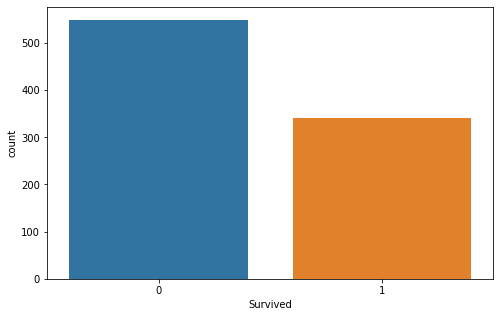

In [897]:
# We then plot the survival rate of the whole data set, 0 means they didn't survive, 1 means they did
plt.figure(figsize=(8,5))
sns.countplot(x='Survived', data= train_data)

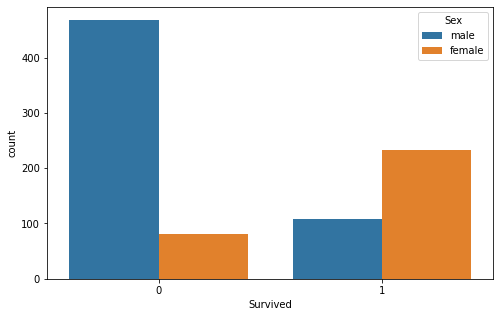

In [898]:
# We then plot the survival rate of men and women
plt.figure(figsize=(8,5))
sns.countplot(x='Survived', hue='Sex', data= train_data)

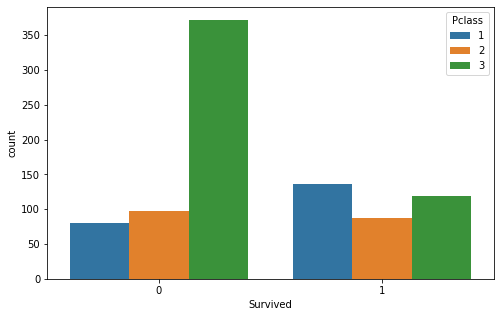

In [899]:
plt.figure(figsize=(8,5))
# This plots the survival rate of the passenger classes
sns.countplot(x='Survived', hue='Pclass', data= train_data)

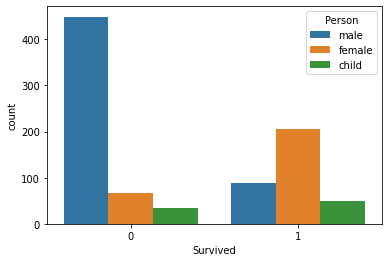

In [900]:
# Method to convert ages to an adult or a child
def titanic_children(passenger):
    
    age , sex = passenger
    if age <16:
        return 'child'
    else:
        return sex

# We want to plot the data on who survived out of a male, female and a child
train_data['Person'] = train_data[['Age','Sex']].apply(titanic_children,axis=1)
sns.countplot(x='Survived', hue='Person', data= train_data)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


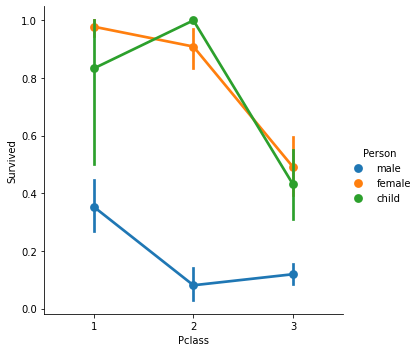

In [901]:
# Plots the survival of male, female and child out of the different passenger classes
sns.factorplot('Pclass','Survived', data=train_data, hue='Person')

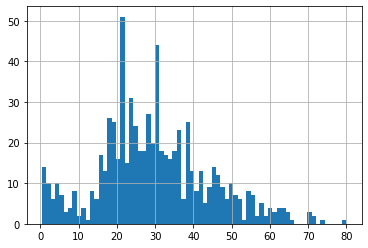

In [902]:
# A histogram plotting the ages of the dataset
train_data['Age'].hist(bins=70)

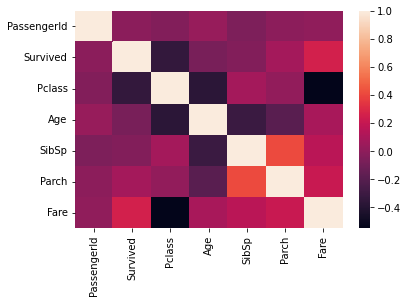

In [903]:
# Shows us the correlation of the data
corr = train_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [904]:
# Explore the dataset
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male


# Data cleaning/ Data preprocessing

In [905]:
# The cols that will drop from the dataframes
cols = ["Name", "Ticket", "Cabin", "Embarked", "Person", "Fare"]
# Drop the cols from the training_data, axis=1 means to drop labels from columns
train_data = train_data.drop(cols, axis=1)

In [906]:

# It drops all rows that has missing data or NaN values.
# We first print out the dataframe to compare the size of dataframe
# after dropping NaN
# This should return 891 entries, with only 712 entries for the age, we need to fill these entries
# With the average age of the rest of the rows
print(train_data.count())
# We get the mean and fill the rest of the rows to keep all 891 entries
train_data["Age"].fillna(train_data["Age"].mean(), inplace=True)
# Drops the NaN values
train_data = train_data.dropna()
# After dropping NaN values, we should still have 891
print(train_data.count())


PassengerId    891
Survived       891
Pclass         891
Sex            891
Age            714
SibSp          891
Parch          891
dtype: int64
PassengerId    891
Survived       891
Pclass         891
Sex            891
Age            891
SibSp          891
Parch          891
dtype: int64


In [907]:
# The encoder maps Sex col from male and female to 0 1 respectively. This is so we can
# Use the scaler on our data
encoder= ce.OrdinalEncoder(cols=['Sex'],return_df=True, mapping=[{'col':'Sex','mapping':{'male':0,'female':1}}])
# Transform the training and test data
train_data = encoder.fit_transform(train_data)
test_data = encoder.fit_transform(test_data)
# Print the train data to ensure the conversion has happened
print(train_data.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch
0            1         0       3    0  22.0      1      0
1            2         1       1    1  38.0      1      0
2            3         1       3    1  26.0      0      0
3            4         1       1    1  35.0      1      0
4            5         0       3    0  35.0      0      0


In [908]:
# X is converted from panadas dataframe to numpy so we can use it in the model
x = train_data.values
# Y is a small output of x that is only the survived column
y = train_data['Survived'].values
# we delete the column Survived from training data
x = np.delete(x, 1, axis=1)

In [909]:
# Create tests and train sets using the sklearn train_test_split giving training set 70% of the data
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Normalization

In [910]:
# We normalize the values. The scaler returns a value between 0 and 1
# First we create the scaler and fit the training data
scaler = MinMaxScaler(feature_range = (0,1))
#We then transform the training and test data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)
print(X_train)

[[0.9640045  0.         0.         0.63443842 0.         0.        ]
 [0.05849269 0.         1.         0.60922728 0.125      0.        ]
 [0.43419573 1.         0.         0.00415984 0.625      0.33333333]
 ...
 [0.70753656 1.         0.         0.36592862 0.         0.        ]
 [0.6287964  1.         1.         0.44535485 0.125      0.        ]
 [0.76940382 0.5        0.         0.74788857 0.125      0.16666667]]


# Machine learning model

In [911]:
# Method to create the MLP model
def mlp_model():
	# Optimizer initialization
	optimizer = Adam(learning_rate = 0.01)
	# create a feedforward model
	model = Sequential()
	# Add an input layer of 6 nodes with relu as the activation function
	model.add(Dense(6, input_dim=6, activation='relu', kernel_initializer="he_normal"))
	# Add a second layer to the mlp with same activation function
	model.add(Dense(12, activation='relu'))
	# Add a final layer to the mlp with a sigmoid activation function
	model.add(Dense(1, activation='sigmoid'))
	# Compile model using binary_crossentropy as the loss function, we use Adam
	# as the optimiser, metrics will show how accurately the model predicts the outcome
	model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer, metrics=['accuracy'])
	# Finally we return the model
	return model

In [912]:
# Build the model
model = mlp_model()
#This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process
#will help to stop "overfitting the model"
#The “monitor” allows you to specify the performance measure to monitor in order to end training
# “mode” argument will need to be specified as whether the objective of the chosen metric is to increase (maximize or ‘max‘) or to decrease (minimize or ‘min‘).
# Patience delays the trigger where we dont see in improvement during epochs
early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=0.01, mode='auto')

# Fit the model using the training data and the outcome which is Y_train from above
# We give the model 30 epochs, this is how many times to iterate, batch size of 10
# This divides that data into 10 batches and process each in parallel. Verbose logs the output
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=10, verbose=1, callbacks=[early_stopping])


Epoch 1/30
63/63 [==============================] - 1s 4ms/step - loss: 0.0949 - accuracy: 0.6982 - val_loss: 0.0692 - val_accuracy: 0.7910

Epoch 00001: val_accuracy did not improve from 0.82463
Epoch 2/30
63/63 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.7897 - val_loss: 0.0658 - val_accuracy: 0.7948

Epoch 00002: val_accuracy did not improve from 0.82463
Epoch 3/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.8042 - val_loss: 0.0642 - val_accuracy: 0.8060

Epoch 00003: val_accuracy did not improve from 0.82463
Epoch 4/30
63/63 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.7929 - val_loss: 0.0653 - val_accuracy: 0.8022

Epoch 00004: val_accuracy did not improve from 0.82463
Epoch 5/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.7961 - val_loss: 0.0645 - val_accuracy: 0.7948

Epoch 00005: val_accuracy did not improve from 0.82463
Epoch 6/30
63/63 [==

# Exploration of Results

In [913]:
# Calculate predictions test dataset
PredTestSet = model.predict(X_test).tolist()

# list to series
se = pd.Series(PredTestSet)

# creating new column of predictions in data_check dataframe
data_check['Prediction'] = se
data_check['Prediction'] = data_check['Prediction'].str.get(0)
# Inspect first 20 predictions
data_check.head(20)

,PassengerId,Survived,Prediction
0,1,0,0.078361
1,2,1,0.074964
2,3,1,0.079163
3,4,1,0.950659
4,5,0,0.475804
5,6,0,0.249226
6,7,0,0.948852
7,8,0,0.939389
8,9,1,0.309445
9,10,1,0.519436


In [914]:
# Survived is from the actual data set....final is from our mlp model making predictions
# We use this method to decide if person survived or not
# Equal or above to 0.5 means person survived
series = []
for val in data_check.Prediction:
    if val >= 0.5:
        series.append(1)
    else:
        series.append(0)
# Store the prediction in result
data_check['SurvivedResult'] = series
# Inspect the data again
data_check.head(20)

,PassengerId,Survived,Prediction,SurvivedResult
0,1,0,0.078361,0
1,2,1,0.074964,0
2,3,1,0.079163,0
3,4,1,0.950659,1
4,5,0,0.475804,0
5,6,0,0.249226,0
6,7,0,0.948852,1
7,8,0,0.939389,1
8,9,1,0.309445,0
9,10,1,0.519436,1


In [915]:
# This shows the number of survived vs did not survive

surived = 0
surivednot = 0
for val in data_check['SurvivedResult']:
    if val == 1 :
        surived = surived +1
    else:
        surivednot = surivednot +1
        
print("Survived :" ,surived)
print("Didn't survive: " , surivednot)

Survived : 68
Didn't survive:  823


In [916]:
# This shows the acccuracy
match = 0
nomatch = 0
for val in data_check.values:
    if val[1] == val[3]:
        match = match +1
    else:
        nomatch = nomatch +1

print("Matched :" ,match)
print("Didn't match: " , nomatch)

Matched : 531
Didn't match:  360


In [917]:
# We evalute the Accuracy and the loss function of the model
score = model.evaluate(X_test, Y_test,verbose=1)
print("The accuracy is : %" , score[1] * 100)
print("The loss is : %" , score[0] * 100)

9/9 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.8134
The accuracy is : % 81.34328126907349
The loss is : % 6.310286372900009


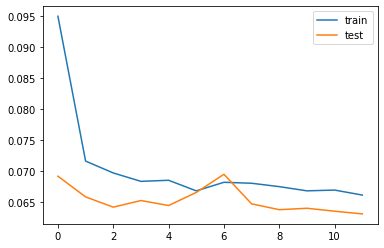

In [918]:
# Plot training history loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

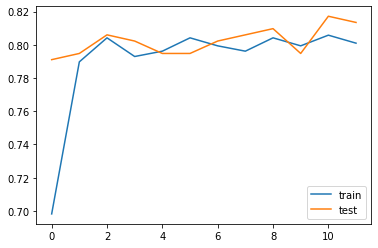

In [919]:
# Plot training history accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

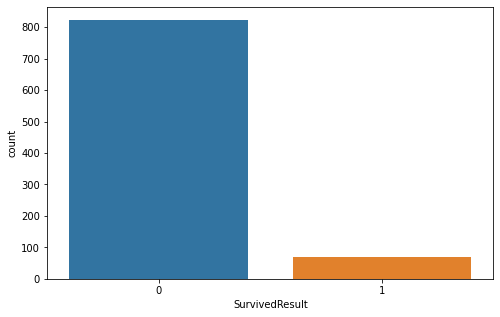

In [920]:
# Survival Rate plotted of the predicted values
plt.figure(figsize=(8,5))
sns.countplot(x='SurvivedResult', data=data_check)

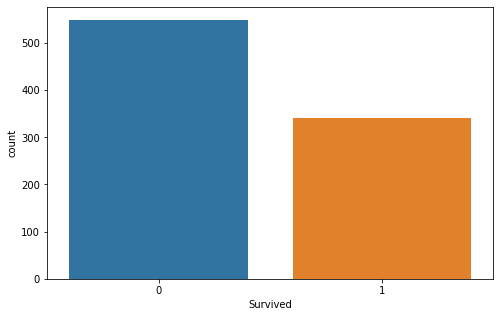

In [921]:
# Compared to survival rate plotted of the actual survival rates
plt.figure(figsize=(8,5))
sns.countplot(x='Survived', data= train_data)

In [922]:

# # data_check = data_check.drop(['Survived'], axis=1)
results = pd.merge(data_check, train_data, on='PassengerId')
results.head()

,PassengerId,Survived_x,Prediction,SurvivedResult,Survived_y,Pclass,Sex,Age,SibSp,Parch
0,1,0,0.078361,0,0,3,0,22.0,1,0
1,2,1,0.074964,0,1,1,1,38.0,1,0
2,3,1,0.079163,0,1,3,1,26.0,0,0
3,4,1,0.950659,1,1,1,1,35.0,1,0
4,5,0,0.475804,0,0,3,0,35.0,0,0


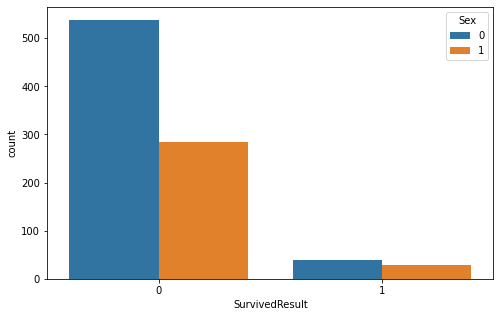

In [923]:
# We then plot the survival rate of men and women using the predicted model
# Where 0 is a man and 1 is woman
plt.figure(figsize=(8,5))
sns.countplot(x='SurvivedResult', hue='Sex', data= results)

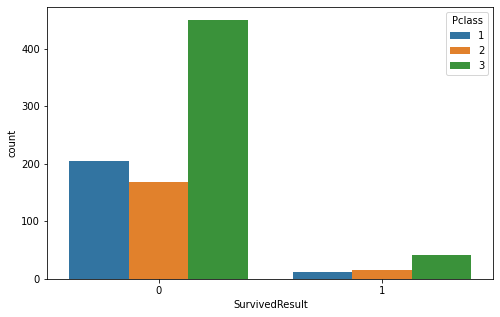

In [924]:
# We then plot the survival rate of men and women in the different passenger classes
plt.figure(figsize=(8,5))
sns.countplot(x='SurvivedResult', hue='Pclass', data= results)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


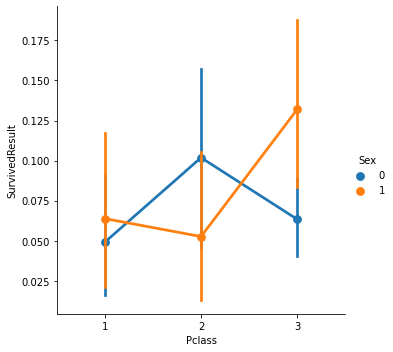

In [925]:
# Plots the survival of male, female and child out of the different passenger classes
sns.factorplot('Pclass','SurvivedResult', data=results, hue='Sex')

In [926]:
# Gradient Boosting is an Ensemble Learning method.
gbc = GradientBoostingClassifier()
# Fit the training data to gbc
gbc.fit(X_train, Y_train)
# Predict the data for the test data
y_pred = gbc.predict(X_test)
# Accuracy is got from sklearn metrics using y_pred and test data
accuracy = accuracy_score(Y_test,y_pred)
print('Accuracy: %f' % accuracy)
# Recall is got from sklearn metrics using y_pred and test data
recall = recall_score(Y_test,y_pred)
print('Recall: %f' % recall)
# Precision is got from sklearn metrics using y_pred and test data
precision = precision_score(Y_test,y_pred)
print('Precision: %f' % precision)
# Matrix is got from sklearn metrics using y_pred and test data
matrix = confusion_matrix(Y_test,y_pred)
print("Confusion Matrix : \n" , matrix)

Accuracy: 0.824627
Recall: 0.620000
Precision: 0.873239
Confusion Matrix : 
 [[159   9]
 [ 38  62]]
